In [1]:
#Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
import glob
import time

#Preprocessing libraries
import random
from utils import get_data, custom_flow, CNN, get_image, test_data

#Model creation libraries
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

from tensorflow.python.keras.backend import set_image_data_format

#Testing libraries
from scikitplot.metrics import plot_roc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

#Augmentation
from augment import aug

#Random seed
seed = 1234

#Visuals
set_image_data_format('channels_last')

### Initial Parameters

In [2]:
#General params.
whatDATA = 'threshold_3sig'
SCALE = True
mask = False

#Network params.
train_size = 1050
test_size = 300
nb_epochs = 500
batch_size = 75
nb_steps_per_epoch = int(train_size/batch_size)
nb_validation_steps = int(test_size/batch_size)

#Cross-validation folds.
k = 5

#Ensambles.
nb_ensambles = 5

#Predictions.
nb_preds = 5

### Training and Cross-Validation

In [3]:
#Split data into folds.
foldsALL = []
labelsALL_1 = []
labelsALL_0 = []
labelsALL = []

#Get data names.
data, data1, data0 = get_data(whatDATA)

for n in range(k):
    fold = np.concatenate((data1[int(n*len(data1)/k):int((n+1)*len(data1)/k)],
                           data0[int(n*len(data0)/k):int((n+1)*len(data0)/k)]), axis = 0)
    
    label1 = [1 for i in range (int(n*len(data1)/k),int((n+1)*len(data1)/k))]
    label0 = [0 for i in range (int(n*len(data0)/k),int((n+1)*len(data0)/k))]
    
    foldsALL.append(fold)
    labelsALL_1.append(label1)
    labelsALL_0.append(label0)
    labelsALL.append((label1, label0))


#Initial report.
print('Ensemble Configuration A\n{}-fold cross validation on {} epochs.\nTrain size: {}\nValidation size: {}\n'
      .format(k, nb_epochs, train_size, test_size))
print('------------------------------------')

startALL = time.time()

#Store metrics and predictions.
mean_loss = []
mean_val_loss = []
mean_acc = []
mean_val_acc = []
pred_mean_folds = []
label_mean_folds = []

#k-fold CV.
for i in range (k):
    start = time.time()
    
    #Split into test and train.
    test1 = foldsALL[i][:len(labelsALL_1[i])]
    test0 = foldsALL[i][len(labelsALL_1[i]):]

    folds_num = [0, 1, 2, 3, 4]
    folds_num.remove(i)

    train1 = []
    train0 = []

    for num in folds_num:
        train1.append(foldsALL[num][:len(labelsALL_1[num])])
        train0.append(foldsALL[num][len(labelsALL_1[num]):])

    trainData_0 = np.concatenate((train0[0], train0[1], train0[2], train0[3]), axis = 0)
    trainData_1 = np.concatenate((train1[0], train1[1], train1[2], train1[3]), axis = 0)
    
    #Specify data generators.
    train_gen = custom_flow(trainData_0,
                            trainData_1,
                            batch_size,
                            augment = True, SCALE = SCALE, mask = mask)

    test_gen = custom_flow(test0,
                           test1,
                           batch_size,
                           augment = True, SCALE = SCALE, mask = mask)

    ensambleFold_pred = []

    pred_labels = []
    epochs = []
    loss = []
    val_loss = []
    acc = []
    val_acc = []

    startFold = time.time()
    #Train ensamble networks.
    for n in range(nb_ensambles):
        start = time.time()

        model = CNN()
        hist = model.fit(train_gen,
                         steps_per_epoch = nb_steps_per_epoch,
                         epochs = nb_epochs,
                         validation_data = test_gen,
                         validation_steps = nb_validation_steps,
                         verbose = 0)


        #Record metrics
        epochs.append(list(range(1, len(hist.history['loss']) + 1)))
        loss.append(hist.history['loss'])
        val_loss.append(hist.history['val_loss'])
        acc.append(hist.history['accuracy'])
        val_acc.append(hist.history['val_accuracy'])
        
        #Get augmentation averaged predictions.
        predictions = []
        predictions_test =[]
        
        for j in range (nb_preds):
            pred0 = [aug(get_image(image, SCALE, mask)) for image in test0]
            pred1 = [aug(get_image(image, SCALE, mask)) for image in test1] 
            
            predictions.append(model.predict(np.concatenate((pred0, pred1))))
            
        label0 = np.zeros(len(pred0))
        label1 = np.ones(len(pred1))        
        
        #Save predictions and labels for network n.
        ensambleFold_pred.append(np.mean(np.array(predictions), axis = 0))
        pred_labels.append(np.concatenate((label0, label1)))
        
        #Progress report.
        finsh = time.time()
        print('Ensamble A model {}/5 trained! ({:.0f} minutes)\n'.format(n+1, (finsh - start)/60))

        #Wait 1 second.
        time.sleep(1)
    
    #Mean metrics for fold.
    mean_loss.append(np.mean(loss, axis = 0))
    mean_val_loss.append(np.mean(val_loss, axis = 0))
    mean_acc.append(np.mean(acc, axis = 0))
    mean_val_acc.append(np.mean(val_acc, axis = 0))
    
    #Get prediction mean for fold.
    pred_matrix = np.concatenate((ensambleFold_pred[0], ensambleFold_pred[1],
                                  ensambleFold_pred[2], ensambleFold_pred[3],
                                  ensambleFold_pred[4]), axis = 1)
    
    #Get predictions and for fold.
    pred_mean_folds.append(np.mean(pred_matrix, axis = 1)) 
    label_mean_folds.append(pred_labels[0])
    
    finish = time.time()
    print('Fold {}/{} Completed!'.format(i+1, k))
    print('Completion time: {:.0f} minutes. \n'.format((finish - startFold)/60))
    if i == k-1:
        print('Total {}-fold CV completion time: {:.0f} minutes ({:.1f} hours).'
              .format(k, (finish - startALL)/60,(finish - startALL)/3600))
    
#Get metrics for all folds.
loss_CV = np.mean(np.array(mean_loss), axis = 0)
val_loss_CV = np.mean(np.array(mean_val_loss), axis = 0)
acc_CV = np.mean(np.array(mean_acc), axis = 0)
val_acc_CV = np.mean(np.array(mean_val_acc), axis = 0)

#Get predictions for all folds.
predA_CV = np.concatenate((pred_mean_folds[0], pred_mean_folds[1], pred_mean_folds[2], 
                          pred_mean_folds[3], pred_mean_folds[4]))

labelA_CV = np.concatenate((label_mean_folds[0], label_mean_folds[1], label_mean_folds[2],
                           label_mean_folds[3], label_mean_folds[4]))
#Save predictions to file.
np.savetxt('predictions_full/ensembleA_CV_predictions_'+ str(nb_epochs) +'.csv', predA_CV, delimiter = ',')
np.savetxt('predictions_full/ensembleA_CV_labels.csv', labelA_CV, delimiter = ',')
print('Predictions saved!')

Ensemble Configuration A
5-fold cross validation on 500 epochs.
Train size: 1050
Validation size: 300

------------------------------------
Ensamble A model 1/5 trained! (43 minutes)

Ensamble A model 2/5 trained! (42 minutes)

Ensamble A model 3/5 trained! (42 minutes)

Ensamble A model 4/5 trained! (42 minutes)

Ensamble A model 5/5 trained! (43 minutes)

Fold 1/5 Completed!
Completion time: 213 minutes. 

Ensamble A model 1/5 trained! (43 minutes)

Ensamble A model 2/5 trained! (43 minutes)

Ensamble A model 3/5 trained! (43 minutes)

Ensamble A model 4/5 trained! (43 minutes)

Ensamble A model 5/5 trained! (43 minutes)

Fold 2/5 Completed!
Completion time: 213 minutes. 

Ensamble A model 1/5 trained! (43 minutes)

Ensamble A model 2/5 trained! (43 minutes)

Ensamble A model 3/5 trained! (43 minutes)

Ensamble A model 4/5 trained! (43 minutes)

Ensamble A model 5/5 trained! (43 minutes)

Fold 3/5 Completed!
Completion time: 214 minutes. 

Ensamble A model 1/5 trained! (43 minutes)



### Performance Evaluation

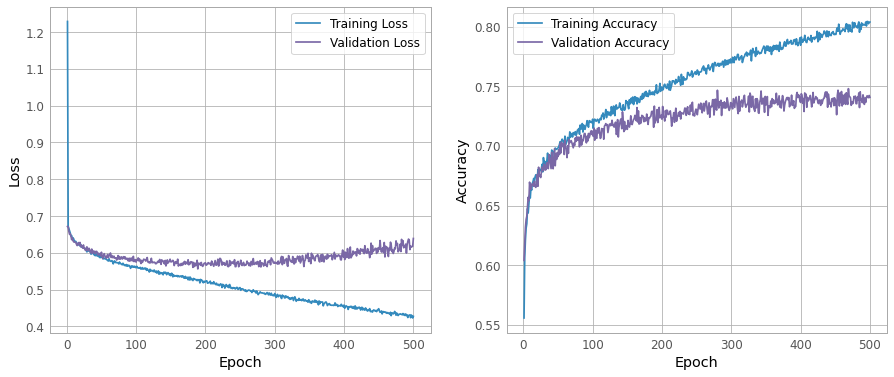

In [4]:
#Plot metrics
fig, ax = plt.subplots(1,2)
fig.set_figwidth(15)

ax[0].plot(np.mean(np.array(epochs), axis = 0), loss_CV, label = 'Training Loss')
ax[0].plot(np.mean(np.array(epochs), axis = 0), val_loss_CV, label = 'Validation Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(np.mean(np.array(epochs), axis = 0), acc_CV, label = 'Training Accuracy')
ax[1].plot(np.mean(np.array(epochs), axis = 0), val_acc_CV, label = 'Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')

#Save plot.
plt.savefig('plots/ensembleA_CV_' + str(nb_epochs) + '.png')
plt.show();